# Pneumonia Detecion with ResNet50

## Dataset

In [10]:
import torch
# data handling
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset
class ChestXrayDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transform=None):
        self.df = df
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label
    


In [2]:
# Organize data paths and labels
import os
import pandas as pd
from sklearn.model_selection import train_test_split

def resolve_data_path(data_dir: str):
    normal_dir = os.path.join(data_dir, 'NORMAL')
    pneumonia_dir = os.path.join(data_dir, 'PNEUMONIA')

    normal_paths = [os.path.join(data_dir, 'NORMAL', f) for f in os.listdir(normal_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
    pneumonia_paths = [os.path.join(data_dir, 'PNEUMONIA', f) for f in os.listdir(pneumonia_dir) if f.endswith(('.jpeg', '.jpg', '.png'))]
    pathes = normal_paths + pneumonia_paths
    labels = [0]*len(normal_paths) + [1]*len(pneumonia_paths)
    return pd.DataFrame({'path': pathes, 'label': labels})

# Base dir
train_df = resolve_data_path("datasets/all_data")
test_df = resolve_data_path("datasets/test")

train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# compute class weights
class_counts = train_df['label'].value_counts().to_dict()
total_samples = len(train_df)
class_weights = {cls: total_samples/count for cls, count in class_counts.items()}
weights = [class_weights[label] for label in train_df['label']]
# ouptput class weights
print("Class Weights:", class_weights)

print(train_df.head(20))

Class Weights: {1: 1.3473921442369607, 0: 3.8785912882298423}
                                                   path  label
3566  datasets/all_data/PNEUMONIA/person1483_bacteri...      1
2866  datasets/all_data/PNEUMONIA/person591_bacteria...      1
2681  datasets/all_data/PNEUMONIA/person361_virus_74...      1
1199  datasets/all_data/NORMAL/NORMAL2-IM-1438-0001....      0
4619  datasets/all_data/PNEUMONIA/person450_bacteria...      1
1008         datasets/all_data/NORMAL/IM-0349-0001.jpeg      0
1295  datasets/all_data/NORMAL/NORMAL2-IM-1261-0001....      0
2688  datasets/all_data/PNEUMONIA/person994_virus_16...      1
3142  datasets/all_data/PNEUMONIA/person1098_bacteri...      1
82    datasets/all_data/NORMAL/NORMAL2-IM-0898-0001....      0
4042  datasets/all_data/PNEUMONIA/person67_bacteria_...      1
5037  datasets/all_data/PNEUMONIA/person886_virus_15...      1
1980  datasets/all_data/PNEUMONIA/person1617_bacteri...      1
4688  datasets/all_data/PNEUMONIA/person333_bacteria... 

In [3]:
# compute the mean and std of images in the training set
import cv2
import tqdm
import numpy as np

def compute_mean_std(df: pd.DataFrame):
    sum_ = 0.0
    sum_squared = 0.0
    num_pixels = 0

    for idx in tqdm.tqdm(range(len(df))[:10]):
        img_path = df.iloc[idx]['path']
        image = cv2.imread(img_path)
        image = image.astype('float32') / 255.0  # Normalize to [0, 1]
        # compute sum and sum of squares for each channel
        sum_ += image.sum(axis=(0, 1))
        sum_squared += (image ** 2).sum(axis=(0, 1))
        num_pixels += image.shape[0] * image.shape[1]

    mean = sum_ / num_pixels
    std = np.sqrt((sum_squared / num_pixels) - (mean ** 2))
    return mean, std
mean, std = compute_mean_std(train_df)
print(f"Mean: {mean}, Std: {std}")

100%|██████████| 10/10 [00:00<00:00, 29.60it/s]

Mean: [0.47240412 0.47240412 0.47240412], Std: [0.25500405 0.25500405 0.25500405]


In [13]:
# Define transforms, dataloaders
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    # Normalize with ImageNet stats, beacause resnet is pretrained on ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Model Training With Cross Validation

In [22]:
from sklearn.metrics import recall_score, f1_score, roc_auc_score

def train_epoch(model, dataloader, criterion, optimizer, scheduler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        scheduler.step(loss)

        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_epoch(model, dataloader, criterion):
    model.eval()
    
    all_preds, all_trues, all_probs = [], [], []
    val_loss = 0.0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss += criterion(outputs, labels).item() * inputs.size(0)
            total += labels.size(0)
            # q: why [:, 1]?
            # a: get the probabilities for the positive class
            probs = torch.softmax(outputs, dim=1)[:, 1]
            preds = (probs >= 0.5).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_trues.extend(labels.cpu().numpy())
    val_loss /= total
    return val_loss, all_preds, all_trues, all_probs

def compute_metrics(all_trues, all_preds, all_probs):
    val_recall = recall_score(all_trues, all_preds, pos_label=1)
    val_specificity = recall_score(all_trues, all_preds, pos_label=0)
    val_f1 = f1_score(all_trues, all_preds, average='weighted')
    val_auc = roc_auc_score(all_trues, all_probs)
    return val_recall, val_specificity, val_f1, val_auc

In [ ]:
from itertools import product
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights, ResNet101_Weights, ResNet152_Weights

# hyperparameters
learning_rates = [1e-4, 3e-5]
batch_sizes = [32, 64]
num_epochs = 5

# Results dict, to check performance of different hyperparameter combinations
results = {}

for lr, bs in product(learning_rates, batch_sizes):
    print(f"Training with lr={lr}, batch_size={bs}")
    
    # Create dataloaders
    train_dataset = ChestXrayDataset(train_df, transform=train_transform)
    val_dataset = ChestXrayDataset(val_df, transform=val_test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=False, num_workers=4)
    
    # Model, criterion, optimizer
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)  # binary classification
    model = model.to(device)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
        _, all_preds, all_trues, all_probs = eval_epoch(model, val_loader, criterion)
        val_recall, val_specificity, val_f1, val_auc = compute_metrics(all_trues, all_preds, all_probs)
        
        val_acc = (val_recall + val_specificity) / 2
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")
        
        results[(lr, bs)] = {'val_recall': val_recall, 'val_specificity': val_specificity, 'val_f1': val_f1, 'val_auc': val_auc}

# Best (by val weighted F1 for balance)
best_params = max(results, key=lambda x: results[x]['val_f1'])
print(f"Best: LR={best_params[0]}, BS={best_params[1]}, Val F1={results[best_params]['val_f1']:.4f}, Recall={results[best_params]['val_recall']:.4f}, Specificity={results[best_params]['val_specificity']:.4f}")
        


Training with lr=0.0001, batch_size=32
Epoch 1/5, Train Loss: 0.1810, Train Acc: 0.9317, Val Acc: 0.9681, Val F1: 0.9743, Val AUC: 0.9941
Epoch 2/5, Train Loss: 0.0809, Train Acc: 0.9737, Val Acc: 0.9629, Val F1: 0.9515, Val AUC: 0.9969
Epoch 3/5, Train Loss: 0.0597, Train Acc: 0.9780, Val Acc: 0.9812, Val F1: 0.9847, Val AUC: 0.9982
Epoch 4/5, Train Loss: 0.0544, Train Acc: 0.9816, Val Acc: 0.9750, Val F1: 0.9809, Val AUC: 0.9983
Epoch 5/5, Train Loss: 0.0381, Train Acc: 0.9857, Val Acc: 0.9684, Val F1: 0.9817, Val AUC: 0.9992
Training with lr=0.0001, batch_size=64
Epoch 1/5, Train Loss: 0.2056, Train Acc: 0.9290, Val Acc: 0.9424, Val F1: 0.9661, Val AUC: 0.9956
Epoch 2/5, Train Loss: 0.0739, Train Acc: 0.9742, Val Acc: 0.9499, Val F1: 0.9719, Val AUC: 0.9981
Epoch 3/5, Train Loss: 0.0564, Train Acc: 0.9795, Val Acc: 0.9407, Val F1: 0.9669, Val AUC: 0.9978
Epoch 4/5, Train Loss: 0.0468, Train Acc: 0.9830, Val Acc: 0.9610, Val F1: 0.9778, Val AUC: 0.9974
Epoch 5/5, Train Loss: 0.0358, 


=== 5-FOLD CV WITH LEARNING CURVES & CONFUSION MATRICES ===


--- Fold 1 ---


/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1, Train Loss: 0.2427, Train Acc: 0.9146, Val Acc: 0.9187, Val F1: 0.9195, Val AUC: 0.9785

--- Fold 2 ---


/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1, Train Loss: 0.2168, Train Acc: 0.9179, Val Acc: 0.9435, Val F1: 0.9503, Val AUC: 0.9915

--- Fold 3 ---


/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1, Train Loss: 0.2613, Train Acc: 0.9056, Val Acc: 0.9224, Val F1: 0.9165, Val AUC: 0.9818

--- Fold 4 ---


/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1, Train Loss: 0.2386, Train Acc: 0.9110, Val Acc: 0.9433, Val F1: 0.9458, Val AUC: 0.9814

--- Fold 5 ---


/home/supercomputing/miniconda3/envs/cv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1, Train Loss: 0.2428, Train Acc: 0.9131, Val Acc: 0.9302, Val F1: 0.9374, Val AUC: 0.9845


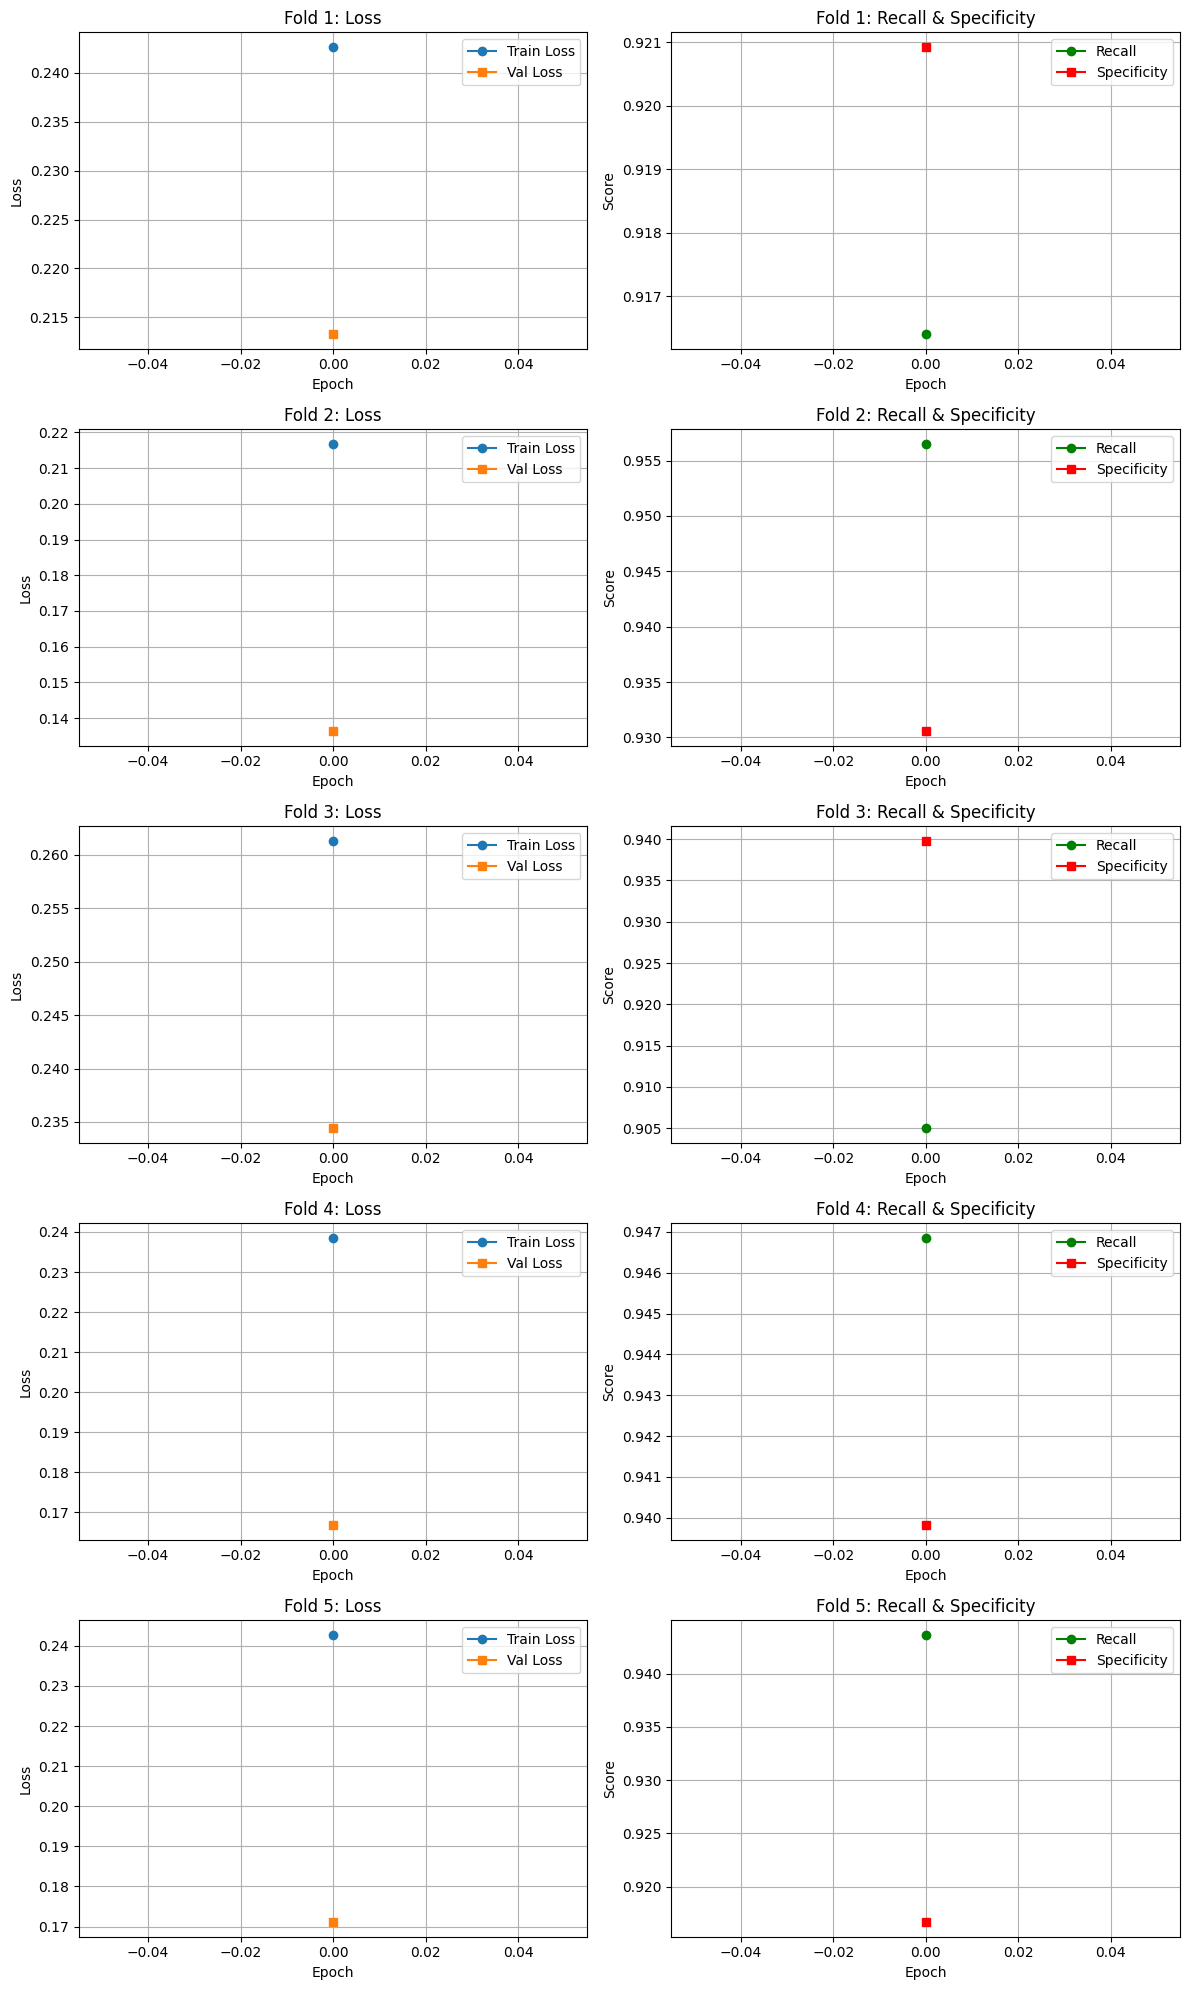

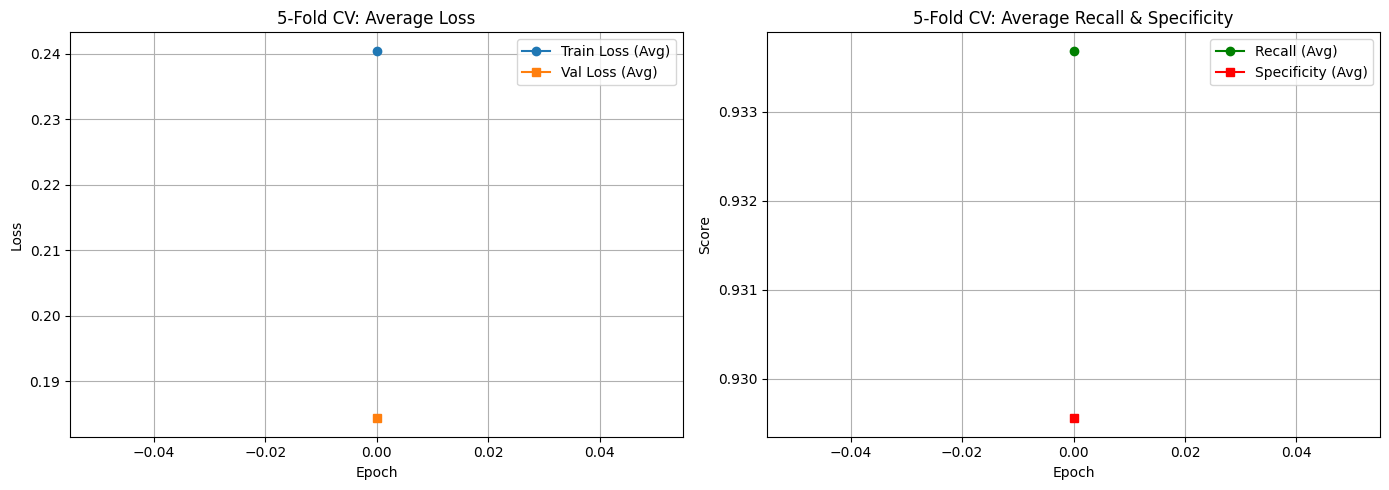

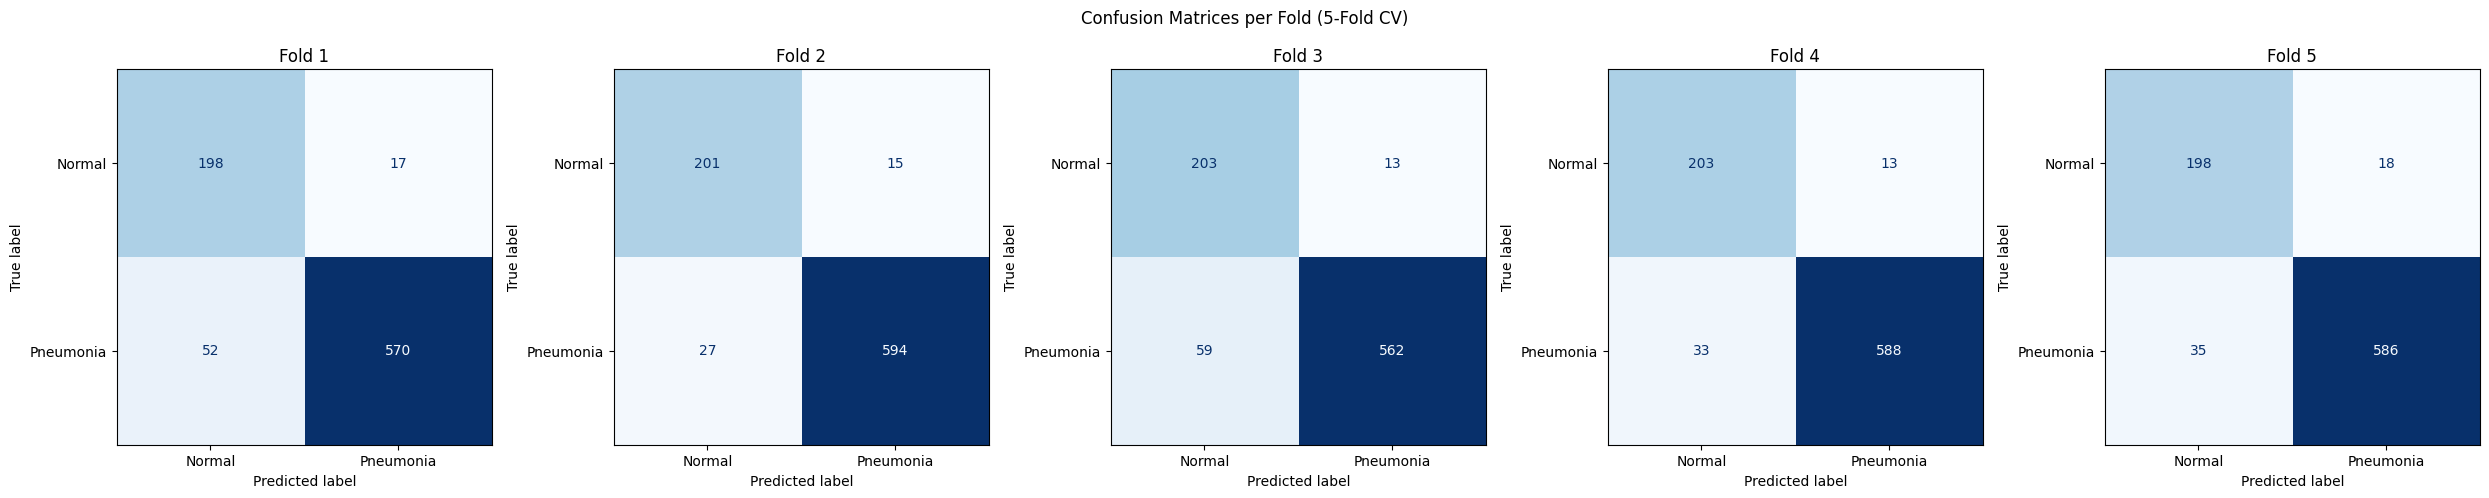


=== 5-FOLD CV FINAL SUMMARY ===
Recall     : 0.9337 ± 0.0196
Specificity: 0.9296 ± 0.0095
F1         : 0.9339 ± 0.0137


In [ ]:
# 5-FOLD LEARNING CROSS VALIDATION
from sklearn.model_selection import StratifiedKFold
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

from matplotlib import pyplot as plt

# chose best batch size
best_BC = 32
# using various learning rates
learning_rates = [1e-4, 3e-5]

# CV setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Storage for CV results
fold_data = [[] for _ in range(5)]  # 5 folds
confuse_matrices = [] #[fold] = confusion_matrix

num_epochs = 12

print("\n=== 5-FOLD CV WITH LEARNING CURVES & CONFUSION MATRICES ===\n")
for fold, (train_index, val_index) in enumerate(kf.split(train_df, train_df['label'])):
    print(f"\n--- Fold {fold+1} ---")
    fold_train_df = train_df.iloc[train_index]
    fold_val_df = train_df.iloc[val_index]
        
    # Create dataloaders
    train_dataset = ChestXrayDataset(fold_train_df, transform=train_transform)
    val_dataset = ChestXrayDataset(fold_val_df, transform=val_test_transform)
    
    train_loader = DataLoader(train_dataset, batch_size=best_BC, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=best_BC, shuffle=False, num_workers=4)
    
    # Model, criterion, optimizer
    model = models.resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = torch.nn.Linear(model.fc.in_features, 2)  # binary classification
    model = model.to(device)
    
    lr = learning_rates[0]
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # set scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)
    
    best_val_acc = 0.0
    
    fold_epoch = []
    all_preds, all_trues = [], []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scheduler)
        val_loss, preds, trues, probs = eval_epoch(model, val_loader, criterion)
        val_recall, val_specificity, val_f1, val_auc = compute_metrics(trues, preds, probs)

        all_preds.extend(preds)
        all_trues.extend(trues)
        
        val_acc = (val_recall + val_specificity) / 2
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val AUC: {val_auc:.4f}")
        
        fold_epoch.append({
            'epoch': epoch+1,
            'train_loss': train_loss,
            'train_acc': train_acc,
            'val_loss': val_loss,
            'val_recall': val_recall,
            'val_specificity': val_specificity,
            'val_f1': val_f1,
            'val_auc': val_auc
        })
    fold_data[fold] = fold_epoch
    confuse_matrices.append(confusion_matrix(all_trues, all_preds))

# ======== INDIVIDUAL LEARNING CURVES PER FOLD ========
fig, axes = plt.subplots(5, 2, figsize=(12, 20))
for fold in range(5):
    epochs = [data['epoch'] for data in fold_data[fold]]
    train_loss = [data['train_loss'] for data in fold_data[fold]]
    val_loss = [data['val_loss'] for data in fold_data[fold]]
    recall = [data['val_recall'] for data in fold_data[fold]]
    specificity = [data['val_specificity'] for data in fold_data[fold]]
    
    axes[fold, 0].plot(train_loss, label='Train Loss', marker='o')
    axes[fold, 0].plot(val_loss,   label='Val Loss',   marker='s')
    axes[fold, 0].set_title(f'Fold {fold+1}: Loss')
    axes[fold, 0].set_xlabel('Epoch')
    axes[fold, 0].set_ylabel('Loss')
    axes[fold, 0].legend()
    axes[fold, 0].grid(True)

    axes[fold, 1].plot(recall, label='Recall',      marker='o', color='green')
    axes[fold, 1].plot(specificity,   label='Specificity', marker='s', color='red')
    axes[fold, 1].set_title(f'Fold {fold+1}: Recall & Specificity')
    axes[fold, 1].set_xlabel('Epoch')
    axes[fold, 1].set_ylabel('Score')
    axes[fold, 1].legend()
    axes[fold, 1].grid(True)
plt.tight_layout()
plt.show()

# === AVERAGED LEARNING CURVES ===
avg_train_loss = np.mean([[data['train_loss'] for data in fold_data[fold]] for fold in range(5)], axis=0)
avg_val_loss = np.mean([[data['val_loss'] for data in fold_data[fold]] for fold in range(5)], axis=0)
avg_recall = np.mean([[data['val_recall'] for data in fold_data[fold]] for fold in range(5)], axis=0)
avg_specificity = np.mean([[data['val_specificity'] for data in fold_data[fold]] for fold in range(5)], axis=0)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Train Loss (Avg)', marker='o')
plt.plot(avg_val_loss,   label='Val Loss (Avg)',   marker='s')
plt.title('5-Fold CV: Average Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(avg_recall, label='Recall (Avg)',      marker='o', color='green')
plt.plot(avg_specificity,   label='Specificity (Avg)', marker='s', color='red')
plt.title('5-Fold CV: Average Recall & Specificity')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === CONFUSION MATRICES ===
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for i, cm in enumerate(confuse_matrices):
    disp = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)
    axes[i].set_title(f'Fold {i+1}')
plt.suptitle('Confusion Matrices per Fold (5-Fold CV)')
plt.tight_layout()
plt.show()

# === FINAL CV SUMMARY ===
# Fix: Access the last epoch's metrics from each fold
final_recalls = [fold_data[i][-1]["val_recall"] for i in range(5)]
final_specs   = [fold_data[i][-1]["val_specificity"] for i in range(5)]
final_f1      = [fold_data[i][-1]["val_f1"] for i in range(5)]

print("\n=== 5-FOLD CV FINAL SUMMARY ===")
print(f"Recall     : {np.mean(final_recalls):.4f} ± {np.std(final_recalls):.4f}")
print(f"Specificity: {np.mean(final_specs):.4f} ± {np.std(final_specs):.4f}")
print(f"F1         : {np.mean(final_f1):.4f} ± {np.std(final_f1):.4f}")
